### Utilizing Embedding to Predict NCAA Games
Inspired by http://www.sloansportsconference.com/wp-content/uploads/2018/02/1008.pdf, an outcome based embedding model, I was tempted to try and predict the outcome of NCAA games. Treating each team as an entity, I look at one season (2017) and see if there is anything to gain from the resulting embeddings afterwards. I then augment the model by jointly estimating the points scored by each team as well, and review the embeddings again. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense, Embedding, Input
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['masseyordinals', 'playbyplay_2016', 'playbyplay_2013', 'playbyplay_2014', 'playbyplay_2010', 'playbyplay_2011', 'playbyplay_2015', 'SampleSubmissionStage1.csv', 'playbyplay_2017', 'playbyplay_2018', 'datafiles', 'playbyplay_2012']


### Data
Here is some simple data pre processing to get us going. 

In [2]:
data_simple = pd.read_csv('../input/datafiles/RegularSeasonCompactResults.csv')


In [3]:
data_simple_2017 = data_simple[data_simple['Season'] == 2017] ### look at 2017 season

In [4]:
teams = list(set(data_simple_2017['WTeamID'].values.tolist() + data_simple_2017['LTeamID'].values.tolist())) ### get all team codes

In [5]:
team_dict = {val:index for index,val in enumerate(teams)} ### get mapping from team to code

In [6]:
data_simple_2017['WCode'] = data_simple_2017['WTeamID'].apply(lambda x: team_dict[x])
data_simple_2017['LCode'] = data_simple_2017['LTeamID'].apply(lambda x: team_dict[x])    #### replace the code with our code

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Model
The model will be set up such that one team will enter on the left, the other on the right. To augment the training data, I will show one team to each "side" of the model. For example, Duke vs. Kansas will appear twice in the data set, one instance where Duke enters the "left" stream, and one instance where it enters the "right" stream. The output is adjusted as such. 

In [7]:
def model_builder(embedding_size,embedding_output_size):
     
    ### left input ###
    left_input = Input(shape = (1,))
    right_input = Input(shape = (1,))
    
    embedding_layer = Embedding(embedding_size,embedding_output_size,input_length=1)
    
    left_encode = embedding_layer(left_input)
    right_encode = embedding_layer(right_input)
    
    
    subtracted = keras.layers.Subtract()([left_encode,right_encode])
#     lay  = Dense(4,activation = 'relu')(subtracted)
    
    out = keras.layers.Dense(2,activation='softmax')(subtracted)
    return keras.models.Model(inputs=[left_input,right_input],outputs=out)


I've used an embedding dimension of 2 and subtracted the embeddings of the right from the left. Here, we are just predicting whether the "left" stream team won.

In [8]:
keras_model = model_builder(351,2)

In [9]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         702         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 1, 2)         0           embedding_1[0][0]                
          

### Train The Model 

In [10]:
train = data_simple_2017.sample(frac = .8)
test = data_simple_2017.drop(train.index)

In [11]:
train_augment = np.zeros((train.shape[0]*2,2))
test_augment = np.zeros((test.shape[0],2))

In [12]:
train_augment[0:train.shape[0],:] = train[["WCode","LCode"]].values
train_augment[train.shape[0]:,:] = train[["LCode","WCode"]].values
X_train = [train_augment[:,0],train_augment[:,1]] #### we augment to remove bias
test_augment[0:test.shape[0],:] = test[["WCode","LCode"]].values
# test_augment[test.shape[0]:,:] = test[["LCode","WCode"]].values
X_test = [test_augment[:,0],test_augment[:,1]]
y_train = np.zeros((train.shape[0]*2,1))
y_train[0:train.shape[0],:] = 1
y_test = np.ones((test.shape[0],1))
# y_test[0:test.shape[0],:] = 1
y_train = keras.utils.to_categorical(y_train,2)
y_test = keras.utils.to_categorical(y_test,2)   

In [13]:
keras_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) ## compile model

In [14]:
history = keras_model.fit(X_train,y_train[:,np.newaxis,:],validation_data=(X_test,y_test[:,np.newaxis,:]),
               epochs=10)

Train on 8632 samples, validate on 1079 samples
Epoch 1/10
8632/8632 [==============================] - 1s 87us/step - loss: 0.6787 - acc: 0.6207 - val_loss: 0.6672 - val_acc: 0.6386
Epoch 2/10
8632/8632 [==============================] - 0s 46us/step - loss: 0.6232 - acc: 0.7157 - val_loss: 0.6166 - val_acc: 0.6821
Epoch 3/10
8632/8632 [==============================] - 0s 46us/step - loss: 0.5661 - acc: 0.7320 - val_loss: 0.5816 - val_acc: 0.7034
Epoch 4/10
8632/8632 [==============================] - 0s 46us/step - loss: 0.5324 - acc: 0.7384 - val_loss: 0.5705 - val_acc: 0.7044
Epoch 5/10
8632/8632 [==============================] - 0s 46us/step - loss: 0.5145 - acc: 0.7455 - val_loss: 0.5646 - val_acc: 0.7108
Epoch 6/10
8632/8632 [==============================] - 0s 46us/step - loss: 0.5042 - acc: 0.7484 - val_loss: 0.5511 - val_acc: 0.7229
Epoch 7/10
8632/8632 [==============================] - 0s 38us/step - loss: 0.4975 - acc: 0.7514 - val_loss: 0.5459 - val_acc: 0.7266
Epoch 8

In [15]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

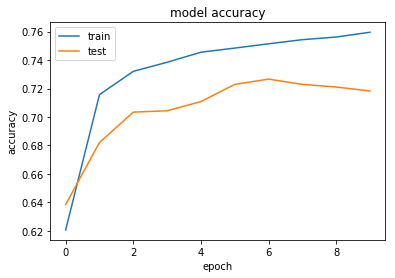

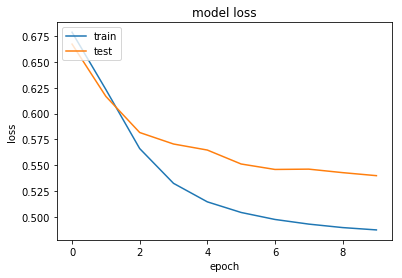

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model is slightly overfit but thats ok. We will now look at the model's predictions.

### Model Criticism

Let's get the teams available and see if our model predicts things which makes sense. 

In [17]:
teams  = pd.read_csv("../input/datafiles/Teams.csv")


In [18]:
name_dict = { row['TeamID']:row['TeamName'] for _,row in teams.iterrows()}
team_name_map = { team_dict[ID]:name for ID,name in name_dict.items() if ID in team_dict}
predictions_whole = keras_model.predict(X_test)
pred_whole = np.squeeze(predictions_whole)
test['WName'] = test['WCode'].apply(lambda x: team_name_map[x])
test['LName'] = test['LCode'].apply(lambda x: team_name_map[x])
test['W Win Prob'] = pred_whole[:,1]
test[['WName',"LName","W Win Prob","WScore","LScore"]]

,WName,LName,W Win Prob,WScore,LScore
145295,Ball St,St Louis,0.581425,85,64
145299,Buffalo,Niagara,0.756079,76,66
145306,Colorado,CS Sacramento,0.870971,90,53
145319,G Washington,MD E Shore,0.925872,75,71
145322,Hofstra,Coppin St,0.898973,74,72
145323,Houston,Morgan St,0.963625,93,52
145331,Louisville,Evansville,0.910549,78,47
145333,Marquette,Vanderbilt,0.392536,95,71
145334,Maryland,American Univ,0.981787,62,56
145353,Ohio St,Navy,0.758819,78,68


Looks reasonable... It also seems games closer in score are harder to predict. A further step would be to add a joint loss to estimate the points produced and use that to additionally produce the win-loss probabilities. 

### Adding a joint loss (predicting points scored)
This will have the same structure as before, however we will increase the embedding dimensionality and also use these dimensions to predict points scored by each team. This will help regularize our model, as well as provide additional predictive information.

In [19]:
def model_builder_joint(embedding_size,embedding_output_size):
     
    ### left input ###
    left_input = Input(shape = (1,))
    right_input = Input(shape = (1,))
    
    embedding_layer = Embedding(embedding_size,embedding_output_size,input_length=1)
    
    left_encode = embedding_layer(left_input)
    right_encode = embedding_layer(right_input)
    
    
    subtracted = keras.layers.Concatenate()([left_encode,right_encode])
    
    predict_points = Dense(2,activation = 'relu')(subtracted)
    concat = keras.layers.Concatenate()([predict_points,subtracted])
#     lay  = Dense(4,activation = 'relu')(subtracted)
    
    out = Dense(2,activation='softmax')(concat)
    
    
    return keras.models.Model(inputs=[left_input,right_input],outputs=[out,predict_points])

In [20]:
joint_model = model_builder_joint(351,5)
joint_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 5)         1755        input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1, 10)        0           embedding_2[0][0]                
          

### Train Joint Model
Just add an additional output here for the y_values since our input is the same.

In [21]:
y_train_joint = np.zeros_like(y_train)
y_train_joint[0:train.shape[0],:] = train[['WScore','LScore']].values
y_train_joint[train.shape[0]:,:] = train[['LScore','WScore']].values
y_test_joint = test[['WScore','LScore']].values


In [22]:
joint_model.compile(optimizer='adam',metrics=['accuracy','mae'],loss=['categorical_crossentropy','mean_squared_error'],
                   loss_weights=[1,1])

In [23]:
history_joint = joint_model.fit(X_train,
                [y_train[:,np.newaxis,:],
                 y_train_joint[:,np.newaxis,:]],
                validation_data=(X_test,[y_test[:,np.newaxis,:],y_test_joint[:,np.newaxis,:]]),
               epochs=100,
                               verbose=False)

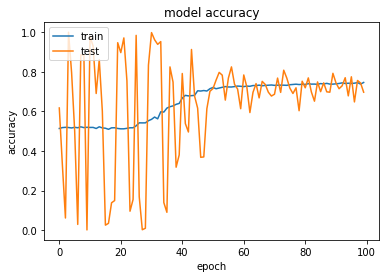

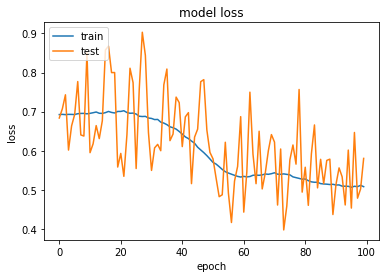

In [24]:
# summarize history for accuracy
plt.plot(history_joint.history['dense_3_acc'])
plt.plot(history_joint.history['val_dense_3_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_joint.history['dense_3_loss'])
plt.plot(history_joint.history['val_dense_3_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We see that since we are jointly estimating the win probabilities, the initial training is unstable! However, over the course of training, we do reach an accuracy of around 70-75% which is what we saw from the original model!

In [25]:
probs,points = joint_model.predict(X_test)
test['W Win Prob Joint'] = np.squeeze(probs)[:,1]
test['W Score'] = np.squeeze(points)[:,0]
test['L Score'] = np.squeeze(points)[:,1]

In [26]:
test.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WCode,LCode,WName,LName,W Win Prob,W Win Prob Joint,W Score,L Score
145295,2017,11,1123,85,1387,64,A,0,19,276,Ball St,St Louis,0.581425,0.732779,69.761589,63.674076
145299,2017,11,1138,76,1310,66,A,0,32,200,Buffalo,Niagara,0.756079,0.772328,83.268738,75.240891
145306,2017,11,1160,90,1170,53,H,0,53,63,Colorado,CS Sacramento,0.870971,0.829263,76.719536,67.216507
145319,2017,11,1203,75,1271,71,H,0,96,163,G Washington,MD E Shore,0.925872,0.888697,79.823792,67.460014
145322,2017,11,1220,74,1164,72,H,0,112,57,Hofstra,Coppin St,0.898973,0.957242,85.056313,67.454941


* Model training seemed to be volatile compared to the original model. However, we see that the joint model changes the win probabilities as a function of the predicted winning score and losing score. Observe how closer games are pushed to .5 and not so close games are pushed to the extremes of 0 and 1. 

### Visualizing Embeddings
We can now visualize the embeddings produced by the model and see if certain points (teams) cluster at certain areas. We will use T-SNE manifold learning to reduce dimensionality.

In [27]:
embeddings = joint_model.get_weights()[0] ### get embeddigns

In [28]:
from sklearn.manifold.t_sne import TSNE ### use tsne to reduce dimensions
t = TSNE(n_components=2)
embed_tsne = t.fit_transform(embeddings)

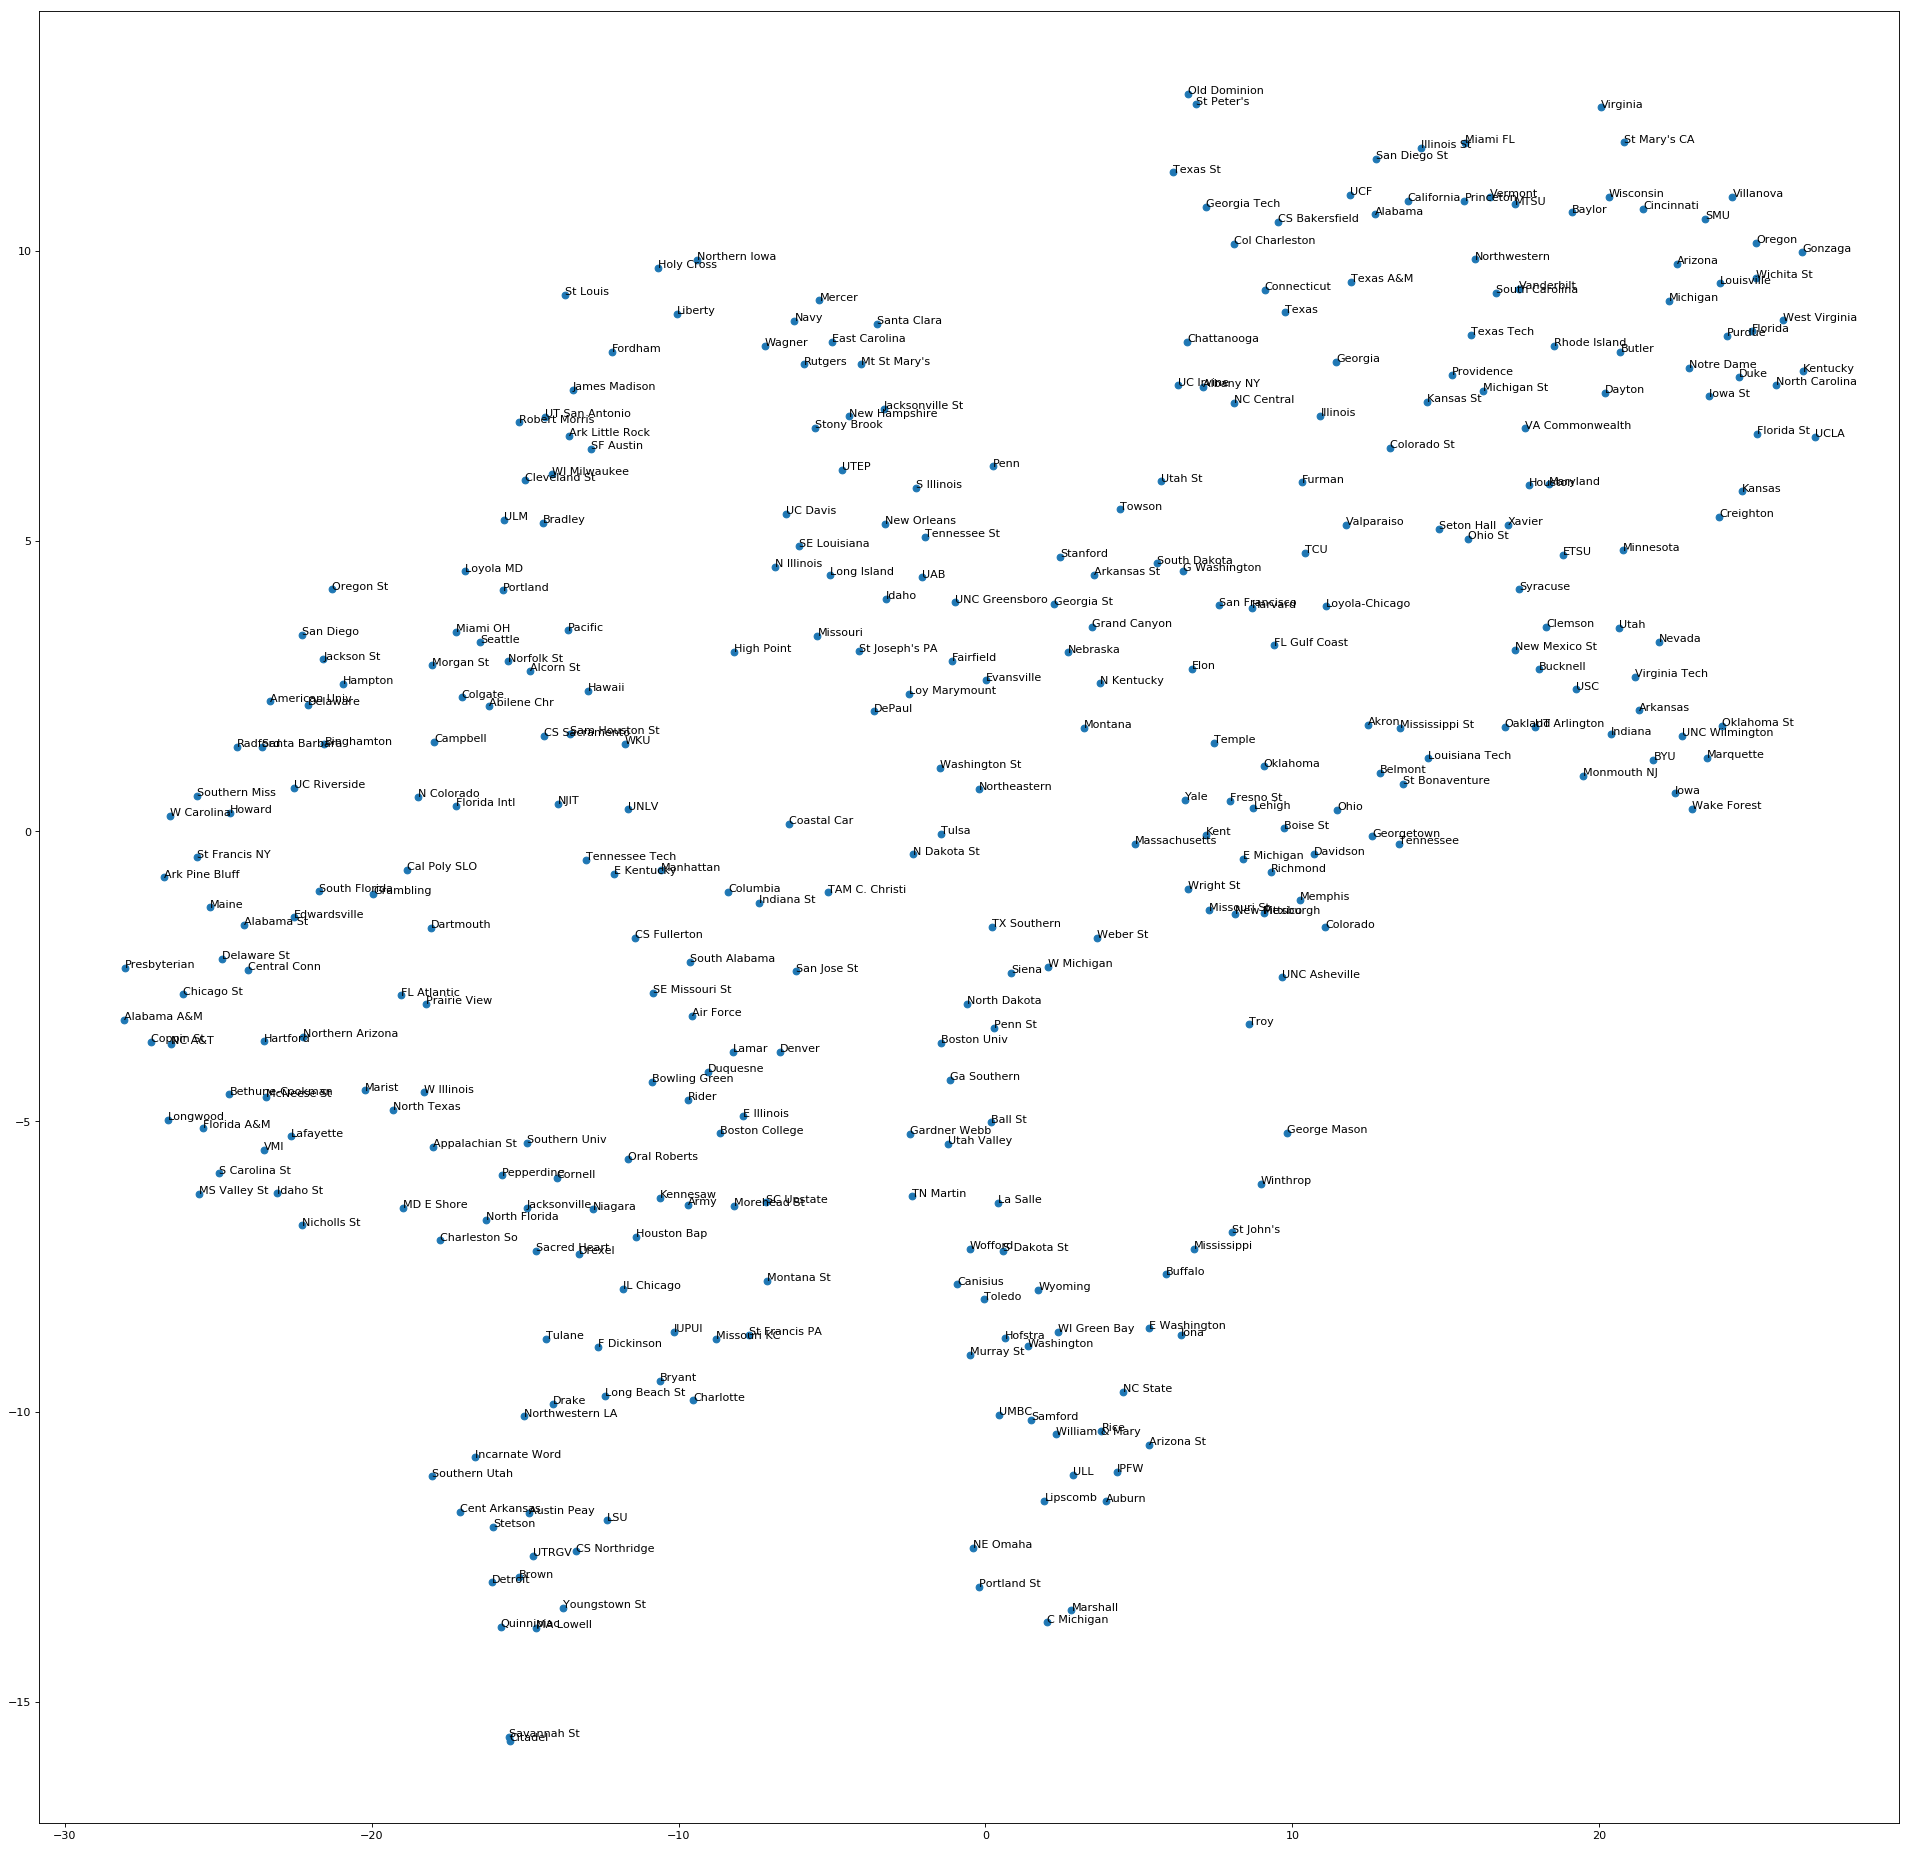

In [29]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(embed_tsne[:,0],embed_tsne[:,1])


names = [val[1] for val in sorted([(key,val) for key,val in team_name_map.items()],key = lambda x: x[0])]
for i, txt in enumerate(names):
    plt.annotate(txt, (embed_tsne[i,0], embed_tsne[i,1]))

We see Villanova, Oregon, UCLA, Oklahoma St., etc (top teams) are located in one corner of the graph. Poorer teams are located in other corners. Interestingly, there are pockets of clusters. These could potentially be a function of points allowed, points scored, games won.

### Takeaways and Conclusions
First and foremost, I'll have to look into adding a home-court indicator as an input. Furthermore, utilizing tensorflow probability, I could implement hierarchical embedding (where the weights for embedding are drawn from a global distribution) as well as adding hierarchical elements for year, conference, etc. As this analysis was only done for the 2016-2017 season, adding hierarchical embedding for the years would be beneficial. 

Looking forward to hearing feedback and comments!